## Spanish Translation - A/B Testing


### Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientist to work on more high level topics.

In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.


### Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

Explain why that might be happening. Are the localized translations really worse?

If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.


[Perform t-test on Total Population](#t-test)  
[Relative Frequency Check](#freq)    
[Decision Tree to check randomization](#dt)    
[Comparison: t-test without Argentina and Uruguay](#comp)    
[t-test by Country](#country)    
[Conclusion](#con)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_df = pd.read_csv("Translation_Test/test_table.csv")
user_df = pd.read_csv("Translation_Test/user_table.csv")

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [5]:
df = test_df.merge(user_df, how ='left', on = 'user_id')

In [6]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [7]:
df.test.value_counts()

0    237338
1    215983
Name: test, dtype: int64

In [8]:
#split test vs control group based on 0 or 1 in test column
test = df[df['test']==1]
control = df[df['test']==0]

In [9]:
print(test.user_id.nunique(),control.user_id.nunique())

215983 237338


In [10]:
#conversion rate by different countries
control.groupby("country")['conversion'].mean().sort_values(ascending = False)

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

#### <a id = 't-test'> Perform t-test <a/>

In [11]:
#remove Spain from data
df1 = df.query('country != "Spain"') 
#null hypothesis assume two populations are equal
t_test = stats.ttest_ind(df1[df1['test'] == 1]['conversion'], 
                         df1[df1['test'] == 0]['conversion'], 
                         equal_var=False)

In [12]:
df1.groupby("test")['conversion'].mean()

test
0    0.048330
1    0.043425
Name: conversion, dtype: float64

In [13]:
print(t_test.statistic, t_test.pvalue)

-7.3939374121344805 1.4282994754055316e-13


Let's assume alpha is equal to 0.05. Since p-vlaue is smaller than 0.05, **we reject the null hypothesis, and there is a difference between the two means.**

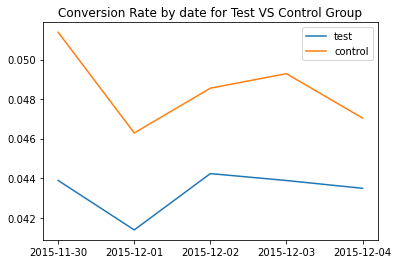

In [14]:
plt.plot(df1.query('test == 1').groupby('date')['conversion'].mean(), label = "test");
plt.plot(df1.query('test == 0').groupby('date')['conversion'].mean(), label = "control");
plt.legend();
plt.title("Conversion Rate by date for Test VS Control Group");

Couple interesting facts:
- Test group always has worse conversion rate compared to control group 
- The test only ran for 5 days which is too short for an experiment

#### <a id = 'freq'>Relative Frequency Check<a/>
To make sure same proportion of users for both control and experiemnt group

In [15]:
#Distribution Check on Source 
tot0 = len(df1.query('test ==0'))
tot1 = len(df1.query('test ==1'))
df1.groupby("source")['test'].agg([('frequency_test_1',lambda x: len(x[x==1])/tot1),  #df1.query('test ==1')
                                   ('frequency_test_0',lambda x: len(x[x==0])/tot0)]) #df1.query('test ==0')


,frequency_test_1,frequency_test_0
source,,
Ads,0.400629,0.401254
Direct,0.199525,0.200947
SEO,0.399846,0.397799


In [16]:
#Distribution Check on Broswer Language 
tot0 = len(df1.query('test ==0'))
tot1 = len(df1.query('test ==1'))
df1.groupby("browser_language")['test'].agg([('frequency_test_1',lambda x: len(x[x==1])/tot1),  #df1.query('test ==1')
                                   ('frequency_test_0',lambda x: len(x[x==0])/tot0)]) #df1.query('test ==0')

,frequency_test_1,frequency_test_0
browser_language,,
EN,0.139520,0.139079
ES,0.832353,0.833317
Other,0.028127,0.027604


In [17]:
#Distribution Check on Broswer Language 
tot0 = len(df1.query('test ==0'))
tot1 = len(df1.query('test ==1'))
df1.groupby("browser_language")['test'].agg([('frequency_test_1',lambda x: len(x[x==1])/tot1),  #df1.query('test ==1')
                                   ('frequency_test_0',lambda x: len(x[x==0])/tot0)]) #df1.query('test ==0')

,frequency_test_1,frequency_test_0
browser_language,,
EN,0.139520,0.139079
ES,0.832353,0.833317
Other,0.028127,0.027604


In [18]:
#Distribution Check on Ads Channel
tot0 = len(df1.query('test ==0'))
tot1 = len(df1.query('test ==1'))
df1.groupby("ads_channel")['test'].agg([('frequency_test_1',lambda x: len(x[x==1])/tot1),  #df1.query('test ==1')
                                   ('frequency_test_0',lambda x: len(x[x==0])/tot0)]) #df1.query('test ==0')

,frequency_test_1,frequency_test_0
ads_channel,,
Bing,0.030164,0.030056
Facebook,0.151104,0.150273
Google,0.150053,0.150677
Other,0.008950,0.009259
Yahoo,0.060357,0.060990


In [19]:
df1.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


#### <a id = 'dt'>Decision Tree to check randomization<a/>
- get rid of conversion and test column will be our label

In [20]:
df1['age'].fillna(df['age'].mean(),inplace = True)

/Users/melissajin/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [21]:
#make date as string, so few dates that makes sense to have them as few dummy values  
# df1['date'] = df1['date'].apply(str)
df_dummy = pd.get_dummies(df1)
#model features, test is the label and conversion is not needed 
train_cols = df_dummy.drop(['test', 'conversion'], axis=1)

In [22]:
df_dummy.head()

,user_id,conversion,test,age,date_2015-11-30,date_2015-12-01,date_2015-12-02,date_2015-12-03,date_2015-12-04,source_Ads,...,country_El Salvador,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,497851,0,1,21.0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,290051,0,1,22.0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,548435,0,1,19.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5,540675,0,1,22.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,863394,0,0,35.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt=DecisionTreeClassifier(class_weight="balanced",#data set is balanced. 
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
dt.fit(train_cols,df_dummy['test'])

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

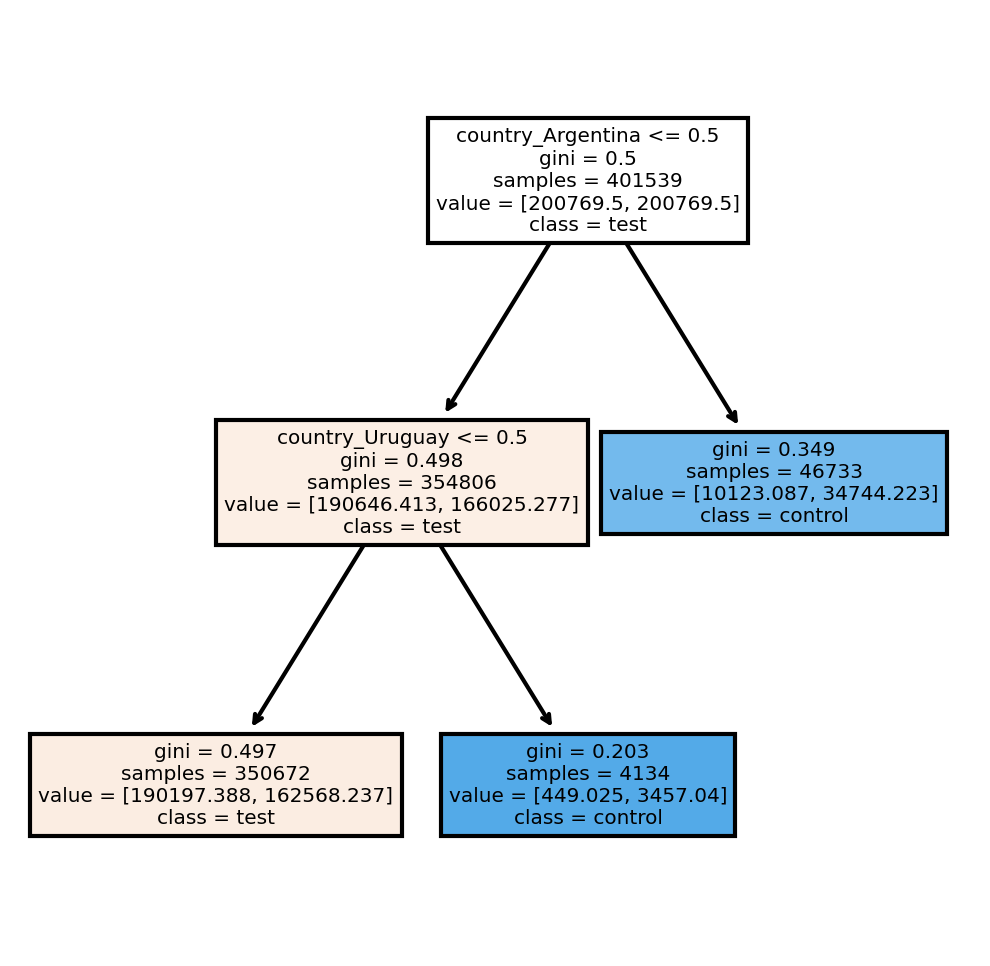

In [24]:
from sklearn import tree
fn=train_cols.columns
#class 1,0
cn=['test','control']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt,feature_names = fn, class_names=cn,filled = True);

**From the decision treer graph above, users from Argentina and Uruguay are more likely to be in test group than control group.**


In [25]:
df_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean()

,country_Argentina,country_Uruguay
test,,
0,0.050421,0.002237
1,0.173055,0.017219


#### <a id = 'comp'> Comparison: t-test without Argentina and Uruguay <a/>

In [26]:
##Original Data
ori_df = stats.ttest_ind(df_dummy[df1['test'] == 1]['conversion'], 
                         df_dummy[df1['test'] == 0]['conversion'], 
                         equal_var=False)

#Data after removing Argentina and Uruguay
remove_df = stats.ttest_ind(df_dummy[(df1['test'] == 1) & 
                                     (df_dummy['country_Argentina'] ==  0) & 
                                     (df_dummy['country_Uruguay'] ==  0)]['conversion'], 
                            df_dummy[(df1['test'] == 0) & 
                                     (df_dummy['country_Argentina'] ==  0) & 
                                     (df_dummy['country_Uruguay'] ==  0)]['conversion'], 
                            equal_var=False)

In [27]:
pd.DataFrame({"Data" : ["Original", "Remove_Argentina_Uruguay"], 
              "p_value" : [ori_df.pvalue, remove_df.pvalue],
              "t_statistic" : [ori_df.statistic, remove_df.statistic]})

,Data,p_value,t_statistic
0,Original,1.428299e-13,-7.393937
1,Remove_Argentina_Uruguay,7.504097e-01,0.318099


With the same alpha is equal to 0.05:
- For origimal data, since p-vlaue is smaller than 0.05, we **reject** the null hypothesis, and **there is a difference between the two means.**
- For data that removed Argentina and Uruguay, since p-vlaue is not smaller than 0.05, we **fail to reject** the null hypothesis, and **there is no difference between the two means.**

#### <a id='country'>t-test by Country<a/>

In [28]:
ttest_country = df1.groupby('country').apply(lambda x: pd.Series(
                                            {'p-value': stats.ttest_ind(
                                                        x.loc[x['test'] == 1,'conversion'], 
                                                        x.loc[x['test'] == 0,'conversion'],
                                                        equal_var=False).pvalue,
                                             'test_conversion':
                                                        x.loc[x['test'] == 1,'conversion'].mean(),
                                             'control_conversion': 
                                                        x.loc[x['test'] == 0,'conversion'].mean()}))

In [29]:
ttest_country.sort_values(by=['p-value'])

,p-value,test_conversion,control_conversion
country,,,
Mexico,0.165544,0.051186,0.049495
El Salvador,0.248127,0.047947,0.053554
Chile,0.302848,0.051295,0.048107
Argentina,0.335147,0.013725,0.015071
Colombia,0.423719,0.050571,0.052089
Honduras,0.471463,0.047540,0.050906
Guatemala,0.572107,0.048647,0.050643
Venezuela,0.573702,0.048978,0.050344
Costa Rica,0.687876,0.054738,0.052256


After control for country and get each country's stats, it seems there is not much difference between test conversion mean and control conversion mean. 

### <a id='con'>Conclusion:<a/>
1. Localized translation doesn't seem to improve conversion rate
2. For Argentina and Uruguay, probably weight adjustments are needed to make sure relative frequency is the same and then re-run the entire test 